#Лабораторная работа 2

Для работы был выбран [этот](https://www.kaggle.com/datasets/andrewmvd/doom-crossing) датасет

##Загрузка датасета

In [1]:
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 79.7/79.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached certifi-2024.2.2-py3-none-any.whl (163 kB)
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102974 sha256=acc1836a793bb5eaf3bc38cd0aed9d8cee0d5d0317c6772894dce56225c4341e
  Stored in directory: c:\users\neuro\appdata\local\pip\cache\wheels\00\74\7d\52c235c074504ceced3dee430f10873c95d8a9e81263ece28e
Successfully built kaggle


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import torch.nn as nn
import opendatasets as od
dataset_url = 'https://www.kaggle.com/andrewmvd/doom-crossing'
od.download(dataset_url)

Skipping, found downloaded files in ".\doom-crossing" (use force=True to force download)


In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import pandas as pd

In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from pathlib import Path
from PIL import Image

import os

C:\Users\Neuro\AppData\Local\Temp\ipykernel_54716\628231294.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


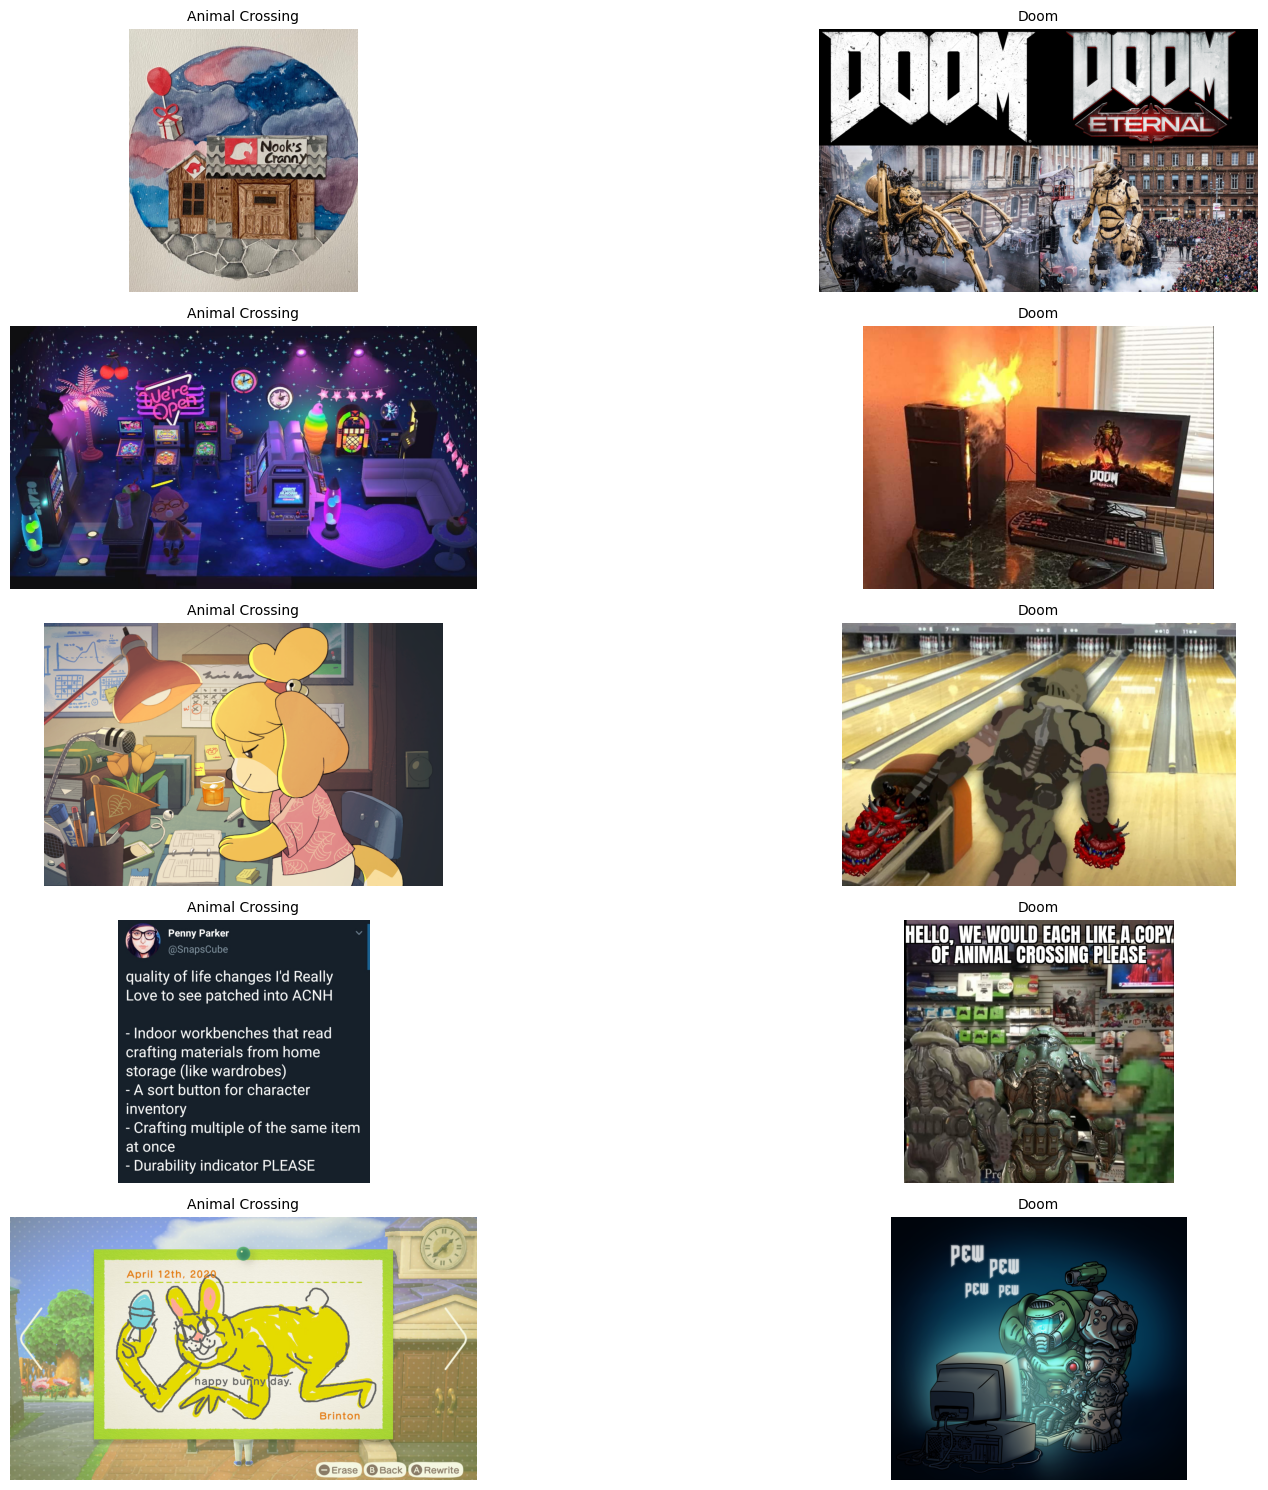

In [6]:
data_path = Path("doom-crossing")
df_ac = pd.read_csv(data_path / "animal_crossing_dataset.csv")
df_doom = pd.read_csv(data_path / "doom_crossing_dataset.csv")

num_images = 5
ac_samples = df_ac.sample(num_images, random_state=0)
doom_samples = df_doom.sample(num_images, random_state=0)

fig = plt.figure(figsize=(20,15))
images = []
for (_, ac), (_, doom) in zip(ac_samples.iterrows(), doom_samples.iterrows()):
    with open(data_path / "animal_crossing" / ac["filename"], "rb") as f_ac, open(data_path / "doom" / doom["filename"], "rb") as f_d:
        ac_img, doom_img = Image.open(f_ac), Image.open(f_d)
        ac_img, doom_img = ac_img.convert("RGB"), doom_img.convert("RGB")
        images.extend([ac_img, doom_img])

for i, image in enumerate(images, start=1):
    ax = plt.subplot(num_images, 2, i)
    ax.axis("off")
    ax.set_title("Animal Crossing" if i % 2 != 0 else "Doom", fontsize=10)
    ax.imshow(image)


fig.tight_layout()
fig.show()

In [12]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import torch.utils.data as data
import torchvision.transforms as tf
from torchvision.io import read_image, ImageReadMode
from imutils import paths
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim import AdamW
from torchmetrics.classification import BinaryAccuracy

In [56]:
class DoomCrossingDataset(data.Dataset):
    def __init__(self, doom_paths, animal_crossing_paths, transforms):
        self.doom_paths = doom_paths
        self.animal_crossing_paths = animal_crossing_paths
        self.transforms = transforms

    # служебный класс, который нужен для torch
    def __len__(self):
            return len(self.doom_paths) + len(self.animal_crossing_paths)

    # служебный класс, который нужен для torch
    def __getitem__(self, idx):
        if idx < len(self.doom_paths):
          image = read_image(self.doom_paths[idx], ImageReadMode.RGB)
          label = torch.tensor(0)
        else:
          image = read_image(self.animal_crossing_paths[idx - len(self.doom_paths)], ImageReadMode.RGB)
          label = torch.tensor(1)
        image = image.permute(1, 2, 0).numpy()
        image = self.transforms(image)

        return image, label

    # класс для получения torch даталоадера принимает batch_size и флаг shuffle - соответствующие аргументы конструктора класса torch.data.DataLoader
    def get_data_loader(self, batch_size, shuffle):
        return data.DataLoader(self, batch_size=batch_size, shuffle=shuffle)


In [49]:
class DatasetLoader:
    @staticmethod
    def get_dataset(doom_path, animal_crossing_path, train_size, batch_size, transform=tf.Compose([tf.ToTensor()])):
        doom_path_image = sorted(list(paths.list_images(doom_path)))
        print(doom_path_image)
        animal_crossing_path_image = sorted(list(paths.list_images(animal_crossing_path)))
        doom_split = train_test_split(doom_path_image, test_size=1.0 - train_size)
        (doom_train_images, doom_test_images) = doom_split
        animal_crossing_split = train_test_split(animal_crossing_path_image, test_size=1.0 - train_size)
        (animal_crossing_train_images, animal_crossing_test_images) = animal_crossing_split
        image_train_trans = DoomCrossingDataset(doom_train_images, animal_crossing_train_images, transform)
        image_test_trans = DoomCrossingDataset(doom_test_images, animal_crossing_test_images, transform)
        return image_train_trans.get_data_loader(batch_size, True), image_test_trans.get_data_loader(batch_size, False)

##Напишем цикл обучения и создадим модель и другие подготовительные этапы

In [50]:
def train_loop(device, model, train_loader, test_loader, train_name_str, loss_function, accuracy_function, statistics, learning_rate=1e-4, num_epoch=5):
  best_epoch = 0
  best_epoch_ind = 0
  optimizer = AdamW(model.parameters(), lr=learning_rate)
  for epoch in range(num_epoch):
      model.train()
      total_loss = 0
      total_accu = 0
      for (i, (x, y)) in tqdm(enumerate(train_loader), total=len(train_loader)):
        (x, y) = (x.to(device), y.to(device))
        optimizer.zero_grad()
        prediction = model(x)
        # print(y, prediction)
        loss = loss_function(prediction, y)
        loss.backward()
        optimizer.step()
        total_loss += loss

      model.eval()
      for (i, (x, y)) in tqdm(enumerate(test_loader), total=len(test_loader)):
        (x, y) = (x.to(device), y.to(device))
        prediction = model(x)
        total_accu += accuracy_function(prediction[:,1] > prediction[:,0], y)

      avg_loss = total_loss / len(train_loader)
      avg_accu = total_accu / len(test_loader)
      statistics["loss"].append(avg_loss.cpu().detach().numpy())
      statistics["accu"].append(avg_accu.cpu().detach().numpy())
      print("[INFO] EPOCH: {}".format(epoch + 1))
      print("loss: {:.4f}, accu: {:.4f}\n".format(avg_loss, avg_accu))

      if best_epoch < avg_accu:
        best_epoch = avg_accu
        best_epoch_ind = epoch + 1
      torch.save(model.state_dict(), "model_weights-" + train_name_str + "-" + str(epoch + 1) + ".pth")
  model.load_state_dict(torch.load("model_weights-" + train_name_str + "-" + str(best_epoch_ind) + ".pth", map_location=torch.device(device)))

 Константы:

In [17]:
kImageSizes = [200, 200]
KlossFn = nn.CrossEntropyLoss()
kLearningRate = 1e-4
kNumEpochs = 10
kAccuFn = BinaryAccuracy(0.5).to(device)

для перехода на сверточные сети уберем последнее преобразование в transforms

In [18]:
kTransforms = tf.Compose([tf.ToTensor(), tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), tf.Resize(kImageSizes)])

Модель 1

In [92]:
model_1 = nn.Sequential(
    nn.Conv2d(3, 8, (3,3), 1),
    nn.Conv2d(8, 8, (3,3), 1),
    nn.AvgPool2d((2,2), 2),
    nn.Conv2d(8, 16, (3,3), 1),
    nn.Conv2d(16, 16, (3,3), 1),
    nn.AvgPool2d((2,2), 2),
    nn.Conv2d(16, 32, (3,3), 1),
    nn.Conv2d(32, 32, (3,3), 1),
    nn.AvgPool2d((2,2), 2),
    nn.Conv2d(32, 32, (3,3), 1),
    nn.Conv2d(32, 32, (3,3), 1),
    nn.AvgPool2d((2,2), 2),
    nn.Conv2d(32, 32, (3,3), 1),
    nn.Conv2d(32, 64, (3,3), 1),
    nn.Conv2d(64, 128, (3,3), 1),
    nn.MaxPool2d((2,2), 2),
    nn.Flatten(),
    nn.Linear(128, 2),
    nn.Sigmoid()
).to(device)

##Попробуем обучить сеть

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_loader, test_loader = DatasetLoader.get_dataset("doom-crossing/doom", "doom-crossing/animal_crossing", 0.8, 16, kTransforms)

cuda
['doom-crossing/doom\\003kprvwysr41.jpg', 'doom-crossing/doom\\01vmlf4buap41.jpg', 'doom-crossing/doom\\032c8pe171q41.png', 'doom-crossing/doom\\04z5q0nunyt41.png', 'doom-crossing/doom\\078yxwtp4gc41.png', 'doom-crossing/doom\\07fili2nses41.jpg', 'doom-crossing/doom\\087sm5ltd8v41.png', 'doom-crossing/doom\\0al47gmk8xs41.jpg', 'doom-crossing/doom\\0c5l0ss550p41.jpg', 'doom-crossing/doom\\0ecs6bzy49051.jpg', 'doom-crossing/doom\\0g8ijg9h5fp41.png', 'doom-crossing/doom\\0i7z32his4251.jpg', 'doom-crossing/doom\\0iihl37qztn41.jpg', 'doom-crossing/doom\\0oinnuls0gp41.jpg', 'doom-crossing/doom\\0p43pkc3jpn41.jpg', 'doom-crossing/doom\\0p7edblbk8p41.jpg', 'doom-crossing/doom\\0q0bg5pzgus41.jpg', 'doom-crossing/doom\\0t3s0u8rw7m41.jpg', 'doom-crossing/doom\\0tdpbogptdi41.jpg', 'doom-crossing/doom\\0u4sc9a1zp831.jpg', 'doom-crossing/doom\\0vvlmn9h7nu41.jpg', 'doom-crossing/doom\\0wovk4f2v0h41.jpg', 'doom-crossing/doom\\13texvno4be41.png', 'doom-crossing/doom\\14rcw19xb0h41.jpg', 'doom-cros

In [94]:
# statistics = {"loss":[], "accu":[]}
train_loop(device, model_1, train_loader, test_loader, "model_1_train", KlossFn, kAccuFn, statistics_1, kLearningRate * 0.1, kNumEpochs)

100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


[INFO] EPOCH: 1
loss: 0.5880, accu: 0.6969



100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


[INFO] EPOCH: 2
loss: 0.5849, accu: 0.6906



100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


[INFO] EPOCH: 3
loss: 0.5831, accu: 0.6781



100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


[INFO] EPOCH: 4
loss: 0.5815, accu: 0.6656



100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


[INFO] EPOCH: 5
loss: 0.5801, accu: 0.6625



100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


[INFO] EPOCH: 6
loss: 0.5791, accu: 0.6625



100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


[INFO] EPOCH: 7
loss: 0.5788, accu: 0.6594



100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


[INFO] EPOCH: 8
loss: 0.5785, accu: 0.6594



100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


[INFO] EPOCH: 9
loss: 0.5778, accu: 0.6594



100%|██████████| 20/20 [00:06<00:00,  2.86it/s]

[INFO] EPOCH: 10
loss: 0.5775, accu: 0.6594



In [47]:
Обучение прошло не очень, но с таким датасетом сложно ожидать от перцептрона каких то
серьёзных результатов (многие из примеров я тоже не смог сходу правильно определить)
проверим на перцептронах с большим количеством слоев, мб они справятся лучше (но не уверен)

SyntaxError: invalid syntax (45527599.py, line 1)

In [95]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(loss, accuracy):
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

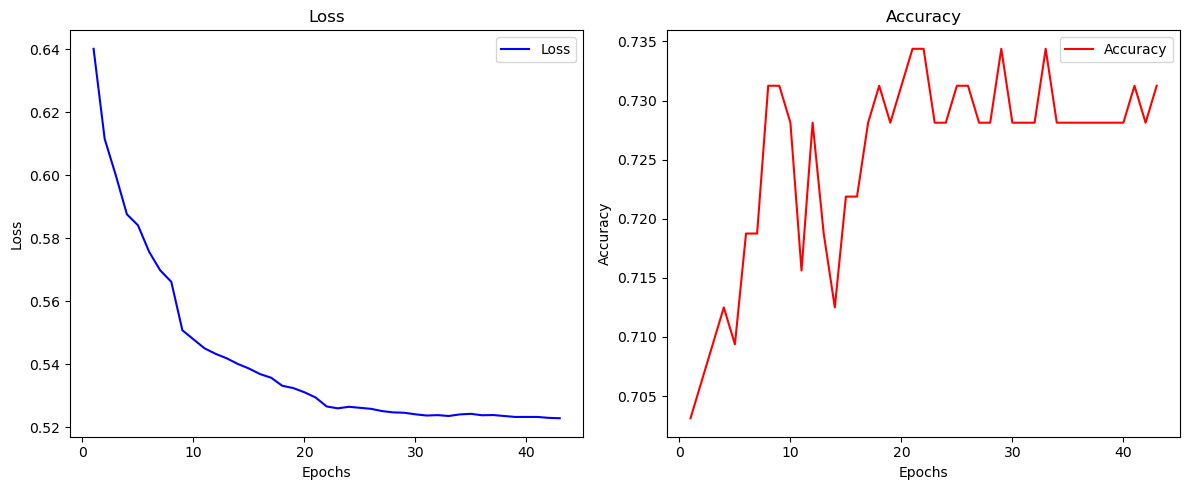

In [99]:
plot_loss_and_accuracy(statistics_1["loss"][:43], statistics_1["accu"][:43])

In [100]:
графики немного ломанные, потому что состоят из нескольких циклов обучений, точность невысокая из за того что 
датасет маленький, кажется что с применение аугментаций и шедулеров получится немного улучшить картину
давайте построим confusion matrix

SyntaxError: invalid syntax (2485276689.py, line 1)

In [103]:
from sklearn.metrics import confusion_matrix

In [101]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model_1(x.to(device)), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


20


In [102]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [104]:
cm = confusion_matrix(labels, predicts, labels=tuple([0,1]))

In [105]:
cm.shape

(2, 2)

In [108]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

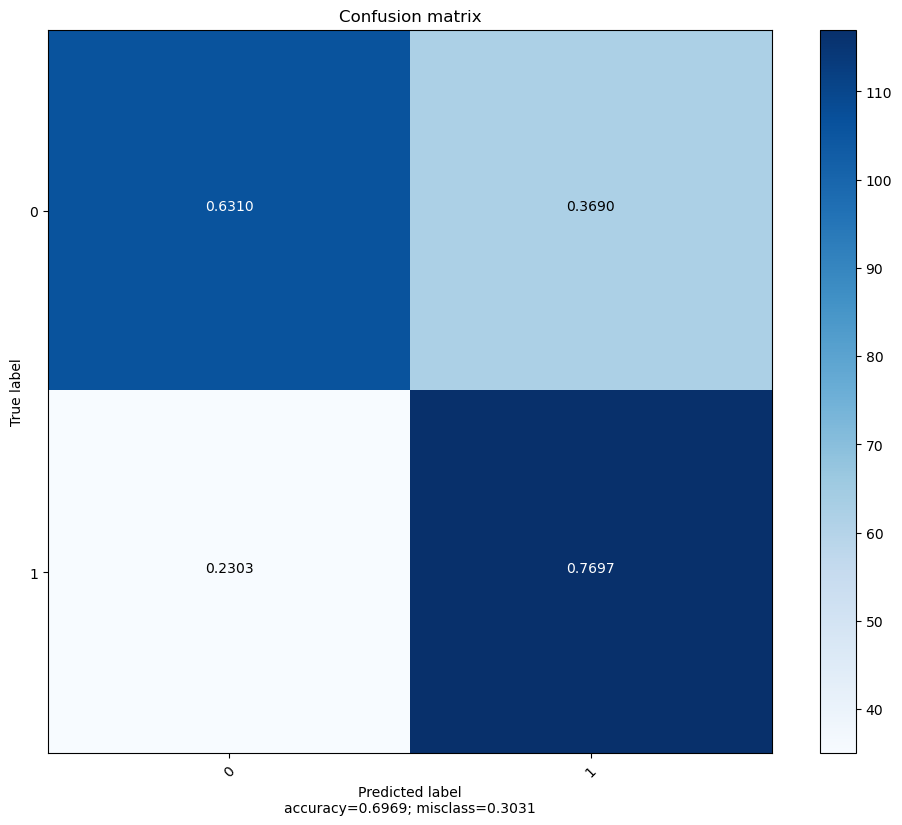

In [109]:
plot_confusion_matrix(cm, tuple([0,1]))